# Libraries


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub

In [2]:
df = pd.read_csv("wine-reviews.csv", usecols = ['country','description','points','price','variety','winery'])

In [3]:
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


In [4]:
df = df.dropna(subset=['description','points'])

In [5]:
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


# Distribution of points


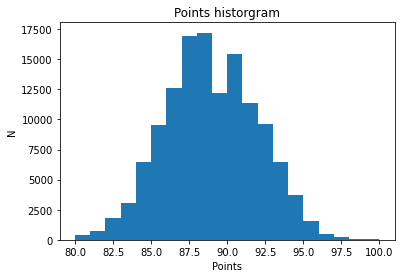

In [6]:
plt.hist(df.points, bins =20)
plt.title("Points historgram")
plt.ylabel("N")
plt.xlabel("Points")
plt.show()

# Classifying reviews below and above 90

In [7]:
  df["label"]=(df.points>=90).astype(int)
  df = df[["description","label"]]
  df.head()

,description,label
0,"Aromas include tropical fruit, broom, brimston...",0
1,"This is ripe and fruity, a wine that is smooth...",0
2,"Tart and snappy, the flavors of lime flesh and...",0
3,"Pineapple rind, lemon pith and orange blossom ...",0
4,"Much like the regular bottling from 2012, this...",0


In [8]:
train, val, test = np.split(df.sample(frac =1), [int(0.8*len(df)), int(0.9*len(df))])

In [9]:
len(train), len(val), len(test)

(103976, 12997, 12998)

In [10]:
def df_to_dataset(dataframe, shuffle=True, batch_size=1024):
  df = dataframe.copy()
  labels = df.pop('label')
  df = df["description"]
  ds = tf.data.Dataset.from_tensor_slices((df, labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

In [11]:
train_data = df_to_dataset(train)
val_data = df_to_dataset(val)
test_data = df_to_dataset(test)

# Embedding + Model: Text embedding nnlm-en-dim50 tensorflow model (transforms text into a vector of numbers)

In [12]:
embedding ="https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, dtype=tf.string, trainable=True)

In [13]:
hub_layer(list(train_data)[0][0])

<tf.Tensor: shape=(1024, 50), dtype=float32, numpy=
array([[ 0.24650222, -0.32238853, -0.03482312, ...,  0.14663008,
        -0.03236693,  0.19605698],
       [ 0.4000638 ,  0.15330774,  0.40589523, ..., -0.06882401,
        -0.26133445,  0.11142654],
       [ 0.2478539 , -0.2202524 , -0.06658012, ...,  0.06203793,
        -0.05637129,  0.01531678],
       ...,
       [ 0.32254583, -0.21961069,  0.07820147, ...,  0.04669762,
        -0.22175469, -0.126792  ],
       [ 0.32462376, -0.05370048,  0.16014847, ...,  0.02653718,
        -0.28708407,  0.06558115],
       [ 0.47858277, -0.23631442, -0.12430889, ..., -0.16196129,
        -0.12340672,  0.10242956]], dtype=float32)>

In [14]:
model =tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation="relu"))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(16, activation="relu"))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

In [15]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.BinaryCrossentropy(), metrics=["accuracy"]) #Binary cross entropy since it is a binary classification problem

In [16]:
model.evaluate(train_data)

102/102 [==============================] - 5s 24ms/step - loss: 0.7051 - accuracy: 0.4113


[0.7050960063934326, 0.4112968444824219]

In [17]:
model.evaluate(val_data)

13/13 [==============================] - 1s 36ms/step - loss: 0.7039 - accuracy: 0.4168


[0.7039486765861511, 0.4167884886264801]

In [18]:
history = model.fit(train_data, epochs = 5, validation_data= val_data)

Epoch 1/5
102/102 [==============================] - 84s 801ms/step - loss: 0.6080 - accuracy: 0.6669 - val_loss: 0.4737 - val_accuracy: 0.7870
Epoch 2/5
102/102 [==============================] - 57s 554ms/step - loss: 0.4530 - accuracy: 0.7940 - val_loss: 0.3967 - val_accuracy: 0.8190
Epoch 3/5
102/102 [==============================] - 57s 555ms/step - loss: 0.3866 - accuracy: 0.8324 - val_loss: 0.3808 - val_accuracy: 0.8238
Epoch 4/5
102/102 [==============================] - 57s 556ms/step - loss: 0.3540 - accuracy: 0.8491 - val_loss: 0.3792 - val_accuracy: 0.8250
Epoch 5/5
102/102 [==============================] - 56s 547ms/step - loss: 0.3317 - accuracy: 0.8599 - val_loss: 0.3810 - val_accuracy: 0.8265


# Chart for training and validation accuracy

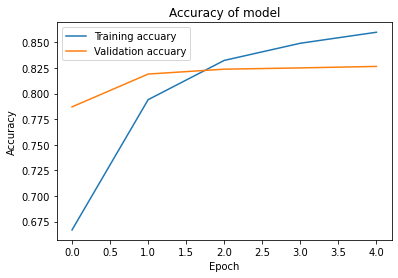

In [19]:
plt.plot(history.history['accuracy'],label="Training accuary")
plt.plot(history.history['val_accuracy'],label="Validation accuary")
plt.title("Accuracy of model")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()

# Chart for training and validation loss

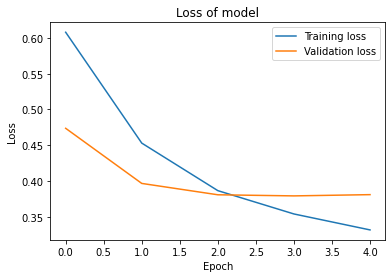

In [20]:
plt.plot(history.history['loss'],label="Training loss")
plt.plot(history.history['val_loss'],label="Validation loss")
plt.title("Loss of model")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

In [21]:
model.evaluate(test_data)

13/13 [==============================] - 1s 73ms/step - loss: 0.3729 - accuracy: 0.8323


[0.3729126751422882, 0.8322818875312805]

# Achieved 83% accuarcy